### Hypertension Detection (MLP)

In this notebook we are going to create a `Multi-Layer Perceptron (MLP)` model that will check the chances for an individual of having `Hypertension` using the following features:

```shell
Age, Salt_Intake, Stress_Score, Sleep_Duration, BMI, Medication, Exercise_Level, Smoking_Status
```

The dataset that is used for this task was found on [`Kaggle - Hypertension Risk Prediction Dataset`](https://www.kaggle.com/datasets/miadul/hypertension-risk-prediction-dataset)


In the following code cell we are going to install all the packages that we are going to use in this notebook.

In [2]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 24.8 MB/s eta 0:00:00


In the following code cell we are going to import all the packages that we are going to use in this notebook.

In [56]:
import warnings
import random
import os
import time
import json

import pandas as pd
import numpy as np
import seaborn as sns

from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from helperfns.visualization import plot_classification_report, plot_complicated_confusion_matrix
from pigmenta import PALETTES

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)

pandas: 2.2.2
numpy: 2.0.2
torch: 2.6.0+cu124


### Seed
In the following code cell we are going to set the seed to all random operations for reproducivity.

In [4]:
SEED = 23
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device
In the following code cell we are going to get `gpu` device if possible

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data
Our dataset that we are going to use will be comming from kaggle. So we are going to download it using the `kaggle` api, in the code cells that follows.

> URL: https://www.kaggle.com/datasets/miadul/hypertension-risk-prediction-dataset

In [6]:
with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']
!kaggle datasets download miadul/hypertension-risk-prediction-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/miadul/hypertension-risk-prediction-dataset
License(s): apache-2.0
  0% 0.00/22.3k [00:00<?, ?B/s]
100% 22.3k/22.3k [00:00<00:00, 51.9MB/s]


In the following code cell we are going to read the `csv` file and check the first `2` rows in the dataset.

In [7]:
dataframe = pd.read_csv("hypertension_dataset.csv")
dataframe.drop(columns=['BP_History', 'Family_History'], inplace=True)
dataframe.Medication = dataframe.Medication.fillna("None")
dataframe.head(2)

,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI,Medication,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,6.4,25.8,None,Low,Non-Smoker,Yes
1,32,11.7,10,5.4,23.4,None,Low,Non-Smoker,No


In the following code cell we are going to convert the numerical values to categorical values except for `Age` column.

In [8]:
def categorize_bmi(bmi):
  if bmi < 18.5:
    return 'Underweight'
  elif 18.5 <= bmi < 25:
    return 'Normal'
  else:
    return 'Overweight'

def categorize_sleep(duration):
  if duration <= 5:
    return 'Short'
  elif 5 < duration <= 8:
    return 'Normal'
  else:
    return 'Long'

def categorize_stress(score):
  if score <= 3.3:
     return 'Low'
  elif 3.3 < score <= 6.6:
     return 'Moderate'
  else:
    return 'High'

def categorize_salt(intake):
  if intake <= 7.13:
    return 'Low'
  elif 7.13 < intake <= 11.76:
    return 'Moderate'
  else:
    return 'High'

dataframe.BMI = dataframe.BMI.apply(categorize_bmi)
dataframe.Sleep_Duration = dataframe.Sleep_Duration.apply(categorize_sleep)
dataframe.Stress_Score = dataframe.Stress_Score.apply(categorize_stress)
dataframe.Salt_Intake = dataframe.Salt_Intake.apply(categorize_salt)
dataframe.head(2)

,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI,Medication,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,Moderate,High,Normal,Overweight,None,Low,Non-Smoker,Yes
1,32,Moderate,High,Normal,Normal,None,Low,Non-Smoker,No


In the following code cell we are going to drop null and na values from the dataframe if they exists.

In [9]:
if any(dataframe.isna().any()):
    dataframe.dropna(inplace=True)

### Data Insights

In this section of the notebook we are going to visualize the relationshp between features. We are going to start by visualizing the distribution of labels in the dataset.

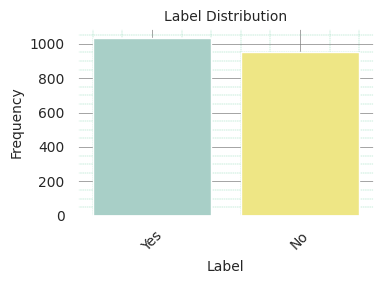

In [10]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(4, 3))
sns.countplot(data=dataframe, x="Has_Hypertension", palette=PALETTES.rainbow[17:])
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.title("Label Distribution", fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

In the next code cell we are going to chech the relationship between the features and the labels, in the dataset on how they are distributed.

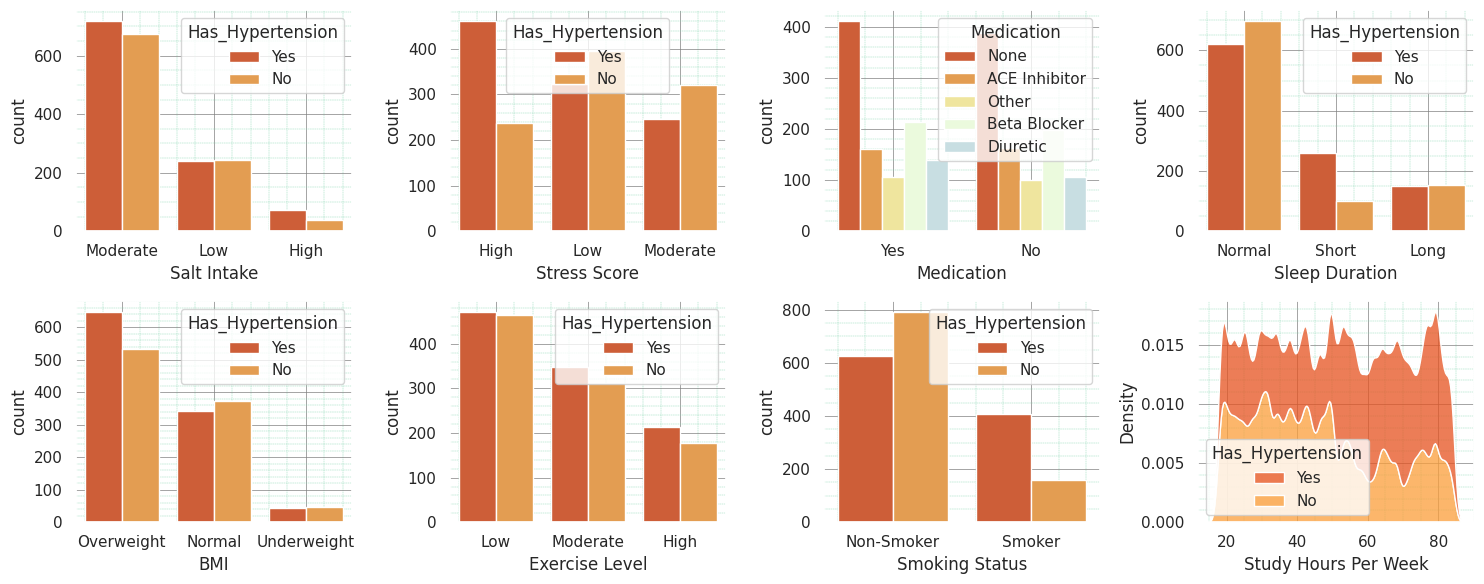

In [11]:
sns.set(font_scale=0.8)
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

fig, axes = plt.subplots(2, 4, figsize=(15, 6), sharey=False)
axes = axes.flatten()

sns.countplot(
    data=dataframe,
    x="Salt_Intake",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[0]
)
axes[0].set(xlabel="Salt Intake")
axes[0].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[0].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[0].minorticks_on()

sns.countplot(
    data=dataframe,
    x="Stress_Score",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[1]
)
axes[1].set(xlabel="Stress Score")
axes[1].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[1].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[1].minorticks_on()

sns.countplot(
    data=dataframe,
    x="Has_Hypertension",
    hue="Medication",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[2]
)
axes[2].set(xlabel="Medication")
axes[2].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[2].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[2].minorticks_on()

sns.countplot(
    data=dataframe,
    x="Sleep_Duration",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[3]
)
axes[3].set(xlabel="Sleep Duration")
axes[3].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[3].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[3].minorticks_on()

sns.countplot(
    data=dataframe,
    x="BMI",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[4]
)
axes[4].set(xlabel="BMI")
axes[4].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[4].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[4].minorticks_on()

sns.countplot(
    data=dataframe,
    x="Exercise_Level",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[5]
)
axes[5].set(xlabel="Exercise Level")
axes[5].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[5].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[5].minorticks_on()

sns.countplot(
    data=dataframe,
    x="Smoking_Status",
    hue="Has_Hypertension",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[6]
)
axes[6].set(xlabel="Smoking Status")
axes[6].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[6].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[6].minorticks_on()

sns.kdeplot(
    data=dataframe,
    x="Age",
    hue="Has_Hypertension",
    bw_adjust=0.2,
    multiple="stack",
    fill=True,
    palette=PALETTES.gradient[13:],
    ax=axes[7]
)
axes[7].set(xlabel="Study Hours Per Week")
axes[7].grid(which='major', color='gray', linestyle='-', linewidth=0.5)
axes[7].grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
axes[7].minorticks_on()

plt.tight_layout()
plt.show()

In the following code cell we are going to split the data into `train` and `test` sets.

In [12]:
train, test = train_test_split(dataframe, test_size=0.2, random_state=SEED)
train, val = train_test_split(train, test_size=0.2, random_state=SEED)

In the following code cell we are going to visualize the examples in each set.

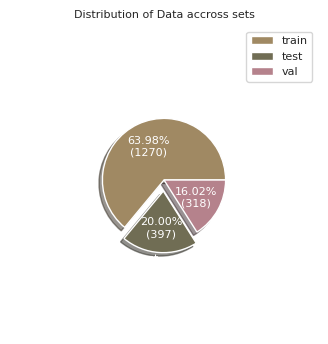

In [13]:
dist_sets = {'train': len(train), 'test': len(test), 'val': len(val)}
def fmt(x, total):
    return '{:.2f}%\n({:.0f})'.format(x, total*x/100)
plt.figure(figsize=(4, 4))
plt.title("Distribution of Data accross sets", fontsize=8)
plt.pie(
    dist_sets.values(), labels=dist_sets.keys(), autopct=lambda x: fmt(x, len(dataframe)),
    textprops={'color': 'white', 'fontsize':8}, radius=.5, explode=[.0, .09, 0],
    colors=PALETTES.fall[14:], shadow=True,
)
plt.legend(fontsize=8)
plt.show()

In the following code cell we are going to extract the features and labels for each set.

In [14]:
X_train = train.drop(columns=['Has_Hypertension'])
y_train = train.Has_Hypertension.values
X_test = test.drop(columns=['Has_Hypertension'])
y_test = test.Has_Hypertension.values
y_val = val.Has_Hypertension.values
X_val = val.drop(columns=['Has_Hypertension'])

y_test[:2]

array(['Yes', 'No'], dtype=object)

In [15]:
X_train.head(2)

,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI,Medication,Exercise_Level,Smoking_Status
1414,72,Moderate,Low,Short,Overweight,None,Moderate,Non-Smoker
101,31,Moderate,Low,Normal,Overweight,ACE Inhibitor,Moderate,Non-Smoker


We are going to create the encoder object using the  `LabelEncoder` that will encode labels to numerical.

In [16]:
encoder = LabelEncoder()
def encode_labels(encoder, train, test, val):
    train = encoder.fit_transform(train.reshape(-1, 1))
    return train.reshape(-1), encoder.transform(test.reshape(-1, 1)).reshape(-1), encoder.transform(val.reshape(-1, 1)).reshape(-1)

train_labels, test_labels, val_labels = encode_labels(encoder, y_train, y_test, y_val)

In the following code cell we are going to check some examples of transformed labels to see if the transformation was successful.

In [17]:
train_labels[:2], y_train[:2], encoder.inverse_transform(train_labels[:2])

(array([1, 0]),
 array(['Yes', 'No'], dtype=object),
 array(['Yes', 'No'], dtype=object))

In the following code cell we are going to transform the features by scaling them using a standard scaler. Features that are not numerical we are going to start by encoding them using the `OrdinalEncoder`

In [18]:
num_features = X_train.columns
num_features

Index(['Age', 'Salt_Intake', 'Stress_Score', 'Sleep_Duration', 'BMI',
       'Medication', 'Exercise_Level', 'Smoking_Status'],
      dtype='object')

In [19]:
num_features[:1]

Index(['Age'], dtype='object')

In [20]:
encode_scale_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder()),
    ('scaler', StandardScaler())
])
scale_pipeline = Pipeline([
    ('ordinal', MinMaxScaler())
])


ct = ColumnTransformer([
    ("encode scale pre-processing", encode_scale_pipeline, num_features[1:]),
    ("scale pre-processing", scale_pipeline, num_features[:1])
])

train_features = ct.fit_transform(X_train)
test_features = ct.transform(X_test)
val_features = ct.transform(X_val)

In the following code cell we are going to check a sigle feature from the training features.

In [21]:
train_features[0]

array([ 0.60767032,  0.10201716,  1.69071566,  0.57393046,  0.71868035,
        1.19968627, -0.64240233,  0.81818182])

In the following code cell we are going to create the dataset using the `TensorDataset` class. After that we are going to batch the dataset using a batch size of `8` using the `DataLoader` class

In [22]:
trainset = TensorDataset(
    torch.from_numpy(train_features).float(), torch.from_numpy(train_labels)
)
testset = TensorDataset(
    torch.from_numpy(test_features).float(), torch.from_numpy(test_labels)
)
valset = TensorDataset(
    torch.from_numpy(val_features).float(), torch.from_numpy(val_labels)
)

BATCH_SIZE = 8

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In the following code cell we are going to create check a single example of training data.

In [23]:
example = next(iter(trainloader))
example[0], example[1]

(tensor([[ 0.6077,  0.1020, -1.8007, -1.2438,  0.7187, -0.2046, -0.6424,  0.1515],
         [ 0.6077, -1.1559, -1.8007,  0.5739,  1.4909, -1.6088, -0.6424,  0.8939],
         [ 0.6077,  0.1020, -0.0550,  0.5739,  0.7187, -0.2046,  1.5567,  0.2424],
         [ 0.6077, -1.1559, -1.8007,  2.3916,  0.7187, -0.2046, -0.6424,  0.9545],
         [-1.1344,  0.1020, -0.0550,  0.5739, -1.5979, -0.2046, -0.6424,  0.7576],
         [-1.1344,  0.1020, -0.0550, -1.2438, -0.0535, -0.2046,  1.5567,  0.9848],
         [ 0.6077,  0.1020, -0.0550,  0.5739, -0.8257, -0.2046, -0.6424,  0.3485],
         [-1.1344,  1.3599, -1.8007,  2.3916,  1.4909, -0.2046, -0.6424,  0.5758]]),
 tensor([0, 1, 0, 1, 0, 0, 1, 0]))

### Creating a Model (MLP)

We are going to use a Linear layers to create a `Multi-layer Perceptron (MLP)` model that does binary classification of `Hypertension`.

In [24]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.classifier = nn.Sequential(
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.BatchNorm1d(256),
      nn.Dropout(0.3),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Dropout(0.2),
      nn.Linear(128, output_dim)
  )

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    x = self.classifier(x)
    return x

The residual MLP.

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Skip connection: input + transformed input
        return x + self.fc(x)

class MLPWithResiduals(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, dropout=0.2):
        super(MLPWithResiduals, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 2 residual blocks
        self.resblock1 = ResidualBlock(hidden_dim, dropout)
        self.resblock2 = ResidualBlock(hidden_dim, dropout)

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.input_layer(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        return self.output_layer(x)


In the following code cell we are going to create the instance of our model.

In [26]:
input_dim = test_features.shape[1]
output_dim = 1 if len(encoder.classes_) == 2 else len(encoder.classes_)
mlp = MLPWithResiduals(input_dim=len(X_train.columns), output_dim=output_dim, dropout=.2).to(device)
mlp

MLPWithResiduals(
  (input_layer): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (resblock1): ResidualBlock(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (resblock2): ResidualBlock(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [27]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

mlp.apply(init_weights)

MLPWithResiduals(
  (input_layer): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (resblock1): ResidualBlock(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (resblock2): ResidualBlock(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

### Counting Model Parameters
In the following code cell we are going to count the model parameters.

In [28]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  return total_params, trainable_params

total_params, trainable_params = count_params(mlp)

tabulate_data(["","Total Parameters", "Trainable Parameteres"],
           [["MLP", f'{total_params:,}', f'{trainable_params:,}']],
           "MODEL PARAMETERS")

MODEL PARAMETERS
+-----+------------------+-----------------------+
|     | Total Parameters | Trainable Parameteres |
+-----+------------------+-----------------------+
| MLP |           35,073 |                35,073 |
+-----+------------------+-----------------------+


### Optimizer and Criterion
In the following code cell we are going to define the `optimizer` and `criterion`. For the optimizer we are going to use the `Adam` optimizer with default parameters and for the criterion we are going to use the `BCEWithLogitsLoss()` function since this is a `binary-class` classification.

In [29]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss().to(device)

In the following code cell we are going to create our `categorical_accuracy` function, which is a function that calulates the the catecorical accuracy between the `predicted` labels and `real` labels.

In [30]:
def binary_accuracy(y_preds, y_true):
  rounded_preds = torch.round(torch.sigmoid(y_preds))
  correct = (rounded_preds == y_true).float()
  acc = correct.sum() / len(correct)
  return acc

### Train and Evaluate functions
In the following code cell we are going to create our `train` and `evalute` functions:

In [36]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device).float()
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    # Calculate the loss and accuracy
    y_pred = y_pred.squeeze()

    loss = criterion(y_pred, y)
    acc = binary_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device).float()
      y_pred = model(x)
      y_pred = y_pred.squeeze()
      loss = criterion(y_pred, y)
      acc = binary_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Training History

When training the model we are going to  keep on tracking the training history of the model. The following `History` class is a data structure for our training history.

In [37]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

### Training Loop
In the following code cell we are going to run the training loop. We are going to save the model when the loss decreased.

In [38]:
EPOCHS = 50
def train_model(model, model_name, train_iterator, optimizer, criterion, device, valid_iterator):
  best_valid_loss = float('inf')
  column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
  last_saved_epoch = 1

  history = History()
  training_start = time.time()
  for epoch in range(EPOCHS):
    start = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    save_status = "(not saving)"
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      save_status = "(saving)"
      last_saved_epoch = epoch + 1
      torch.save(model.state_dict(), model_name)

    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)


    data_rows = [
        ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
    ]

    title = f"{model_name.replace('.pt', '')}: EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
    tabulate_data(column_names, data_rows, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [39]:
history, training_end, last_saved_epoch = train_model(
    mlp, 'mlp.pt', trainloader, optimizer, criterion, device, valloader
)

mlp: EPOCH 01/50: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.758 |   60.67% | 0:00:00.75 |
| Validation | 0.637 |   64.69% |            |
+------------+-------+----------+------------+
mlp: EPOCH 02/50: (saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.704 |   61.98% | 0:00:00.63 |
| Validation | 0.626 |   63.44% |            |
+------------+-------+----------+------------+
mlp: EPOCH 03/50: (not saving)
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.715 |   59.64% | 0:00:00.64 |
| Validation | 0.646 |   63.75% |            |
+------------+-------+----------+------------+
mlp: EPOCH 04/50: (not saving)
+------------+-------+----------+-----

In the following code cell we are going to visualize the model's training history and last saved epoch.

In [40]:
rows = [
      ["MLP", f'{EPOCHS}', f'{last_saved_epoch}', f'{hms_string(training_end)}']
]
tabulate_data(['MODEL', 'TOTAL EPOCHS', "LAST SAVED EPOCH", "TOTAL TRAINING TIME (s)"],
              rows, "MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL'S TOTAL TRAINING TIME AND LAST SAVED EPOCH
+-------+--------------+------------------+-------------------------+
| MODEL | TOTAL EPOCHS | LAST SAVED EPOCH | TOTAL TRAINING TIME (s) |
+-------+--------------+------------------+-------------------------+
| MLP   |           50 |               50 |              0:00:35.83 |
+-------+--------------+------------------+-------------------------+


### Training History
In the following code cells we will be visualizing the training that we observed during training the model. The first plot that we will plot is about the training time that the model took to complete each epoch.

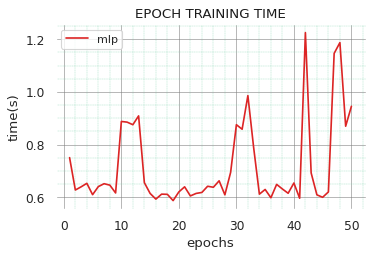

In [41]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.christmas[1], label='mlp')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next we are going to visualize the training and validation loss using a line graph for the model that was observed during model training.

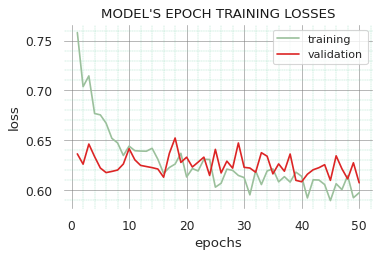

In [42]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.christmas[0], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.christmas[1], label='validation')
plt.title("MODEL'S EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

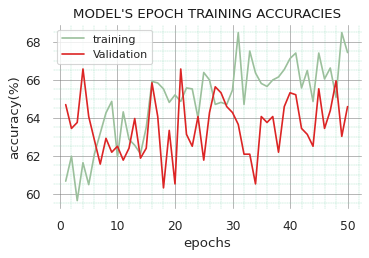

In [43]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.christmas[0], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.christmas[1], label='Validation')

plt.title("MODEL'S EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### Evaluating the best model.
In the following code cell we are going to evaluate the best model using on the `test` data as follows:

In [44]:
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
mlp.load_state_dict(torch.load('mlp.pt'))
test_loss, test_acc = evaluate(mlp, testloader, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]
tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.579 |   71.40% |            |
+------+-------+----------+------------+


### Confusion Matrix
In this section we are going to plot the confusion matrix based on the testing data.

In [54]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (X, y) in iterator:
      X = X.to(device)
      y_pred = torch.sigmoid(model(X)).squeeze().cpu().tolist()
      predictions.extend([1 if i >= 0.5 else 0 for i in y_pred ])
      labels.extend(y.cpu().tolist())
  return labels, predictions
y_true, y_preds = get_predictions(mlp, testloader, device)
classes = encoder.classes_

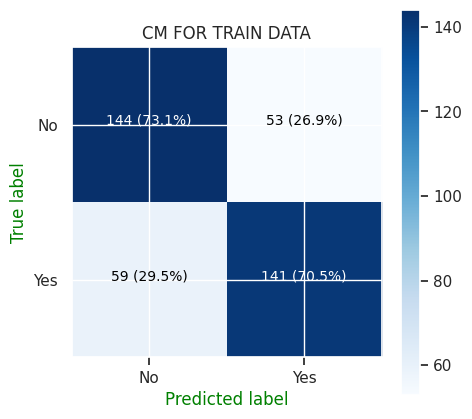

In [58]:
plot_complicated_confusion_matrix(y_true, y_preds,
  classes, fontsize=10, figsize=(5, 5), title="CM FOR TRAIN DATA"
)

### Classification Report.

In this section we are going to plot the classification report based on the testing data.

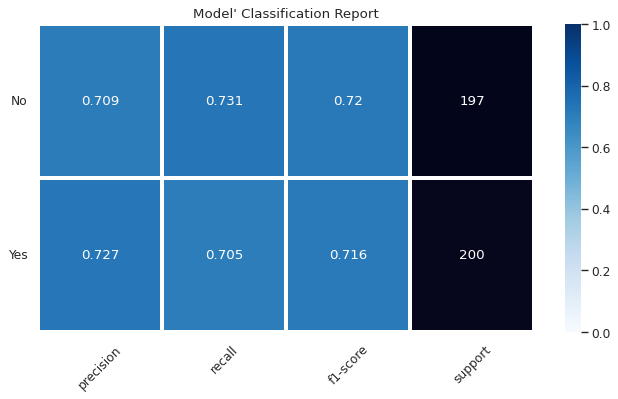

In [59]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Model\' Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = classes
)

### Model Inference

In this section of the notebook we are going to make prediction based on the user input using the best save model.

In [60]:
test.head(2)

,Age,Salt_Intake,Stress_Score,Sleep_Duration,BMI,Medication,Exercise_Level,Smoking_Status,Has_Hypertension
1337,70,Low,Low,Normal,Overweight,Diuretic,High,Smoker,Yes
369,18,Low,Low,Normal,Overweight,None,High,Smoker,No


Predicting `Has_Hypertension`.

In [61]:
details = { "Age": 70, "Salt_Intake": "Low",
           "Stress_Score": 'Low', "Sleep_Duration": 'Normal',
            "BMI": 'Overweight', "Medication": 'Diuretic', "Exercise_Level": 'High',
            'Smoking_Status': 'Smoker'}

def recommend_crop(details, model, device):
  features = pd.DataFrame([details])[num_features]
  features = ct.transform(features)
  features = torch.from_numpy(features).float()
  model.eval()
  with torch.no_grad():
    features = features.to(device)
    y_pred = model(features)
    prob = float(torch.sigmoid(y_pred.squeeze()).item())
    label = 0 if prob < 0.5 else 1
    top = {
        "Has_Hypertension": encoder.classes_[label],
        "probability": prob if prob >= 0.5 else 1 - prob,
        "label": label
    }
    return { "prediction": top}
recommend_crop(details, mlp, device)

{'prediction': {'Has_Hypertension': 'Yes',
  'probability': 0.7028304934501648,
  'label': 1}}

Predicting `Has_No_Hypertension`

In [62]:
details = { "Age": 18, "Salt_Intake": "Low",
           "Stress_Score": 'Low', "Sleep_Duration": 'Normal',
            "BMI": 'Overweight', "Medication": 'None', "Exercise_Level": 'High',
            'Smoking_Status': 'Smoker'}
recommend_crop(details, mlp, device)

{'prediction': {'Has_Hypertension': 'No',
  'probability': 0.6481745839118958,
  'label': 0}}

### Saving Objects

In the following code cell we are going to save all the objects that we are going to use for inference.

In [63]:
dump({
    "model": num_features,
    "column_transformer": ct,
    "encoder": encoder
}, "crop_recommendation_bundle.joblib")
print("Done!")

Done!
